In [1]:
# imports 
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
import numpy as np 
from torch.optim import Adam 
import matplotlib.pyplot as plt 
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd 

/Users/noelkamm/eeg_llm/eeg_tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define global variables 
NUM_OBSV = 10000                     # number of generated observations  
SEQ_LEN = 100                       # length of the sequence 
NOISE = 0.5                           # level of noise 
MEAN1 = 1                           # mean of the first pulse 
STD1 = 0.3                          # standard deviation of the first pulse 
MEAN2 = 2                           # mean of the second pulse 
STD2 = 0.3                          # standard deviation of the second pulse 
TEST_SIZE = 0.2                     # size of the test set 
BATCH_SIZE = 16                     # batch size 
RANDOM_STATE = 42                   # random initialization for reproducability 
PRED_LENGTH = 50                    # length of the prediction 
CONTEXT_LENGTH = 49                 # length of the context window 
NUM_TIME_FEAT = 1                   # number of time features 
ENC_LAYERS = 2                      # number of encoding layers 
DEC_LAYERS = 2                      # number of decoding layers 
INPUT_FEAT = 2                      # number of input features 
LAG_SEQ = [1]                       # lag sequence 
D_MODEL = 64                        # dimension of the model 
N_HEADS = 8                         # number of attention heads
DISTR = 'normal'                    # output distribution  
NUM_SAMPLES = 1                    # number of parallel generated samples 
NUM_EPOCHS = 20                     # number of epochs 
LEARNING_RATE = 1e-3                # learning rate 

In [3]:
def gaussian(t, mean, std):
    """
    Computes the Gaussian (normal distribution) value for each point in time.

    Parameters:
    t (array-like): The input time points at which to evaluate the Gaussian function.
    mean (float): The mean (center) of the Gaussian distribution.
    std (float): The standard deviation (spread or width) of the Gaussian distribution.

    Returns:
    ndarray: A 1D array of shape (t,)
    """
    
    return 1/np.sqrt(2*np.pi*std**2)*np.exp(-(t-mean)**2/(2*std**2))


In [4]:
def generate_pulse_data(num_samples=NUM_OBSV, seq_len=SEQ_LEN, noise=NOISE, mean1=MEAN1, std1=STD1, mean2=MEAN2, std2=STD2, seed=42):
    """
    Generates synthetic pulse data with time-shifted Gaussian pulses and random noise.

    Parameters:
    num_samples (int): The number of pulse samples to generate. Each sample contains two pulses. 
    seq_length (int): The number of time points in each pulse sequence.
    noise (float): The standard deviation of the noise added to the pulse amplitudes. 

    Returns:
    ndarray: A 3D array of shape (num_samples, seq_length, 2)
    """
    np.random.seed(seed)
    data = []

    for _ in range(num_samples):
        phase_shift = np.random.randn(1)
        t = np.linspace(0, 5, seq_len) + phase_shift

        pulse1 = gaussian(t, mean1, std1) + noise * np.random.randn(seq_len)
        pulse2 = gaussian(t, mean2, std2) + noise * np.random.randn(seq_len)

        sample = np.stack([pulse1, pulse2], axis=1)
        data.append(sample)
    data = np.array(data)
    return data

In [5]:
def split_data(data, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    """
    Splits the input data into training and testing set.

    Parameters:
    data (array-like): The input data to be split.
    test_size (float): The proportion of the data to include in the test split.
    random_state (int, optional): Controls the shuffling applied to the data before the split. 

    Returns:
    tuple: A tuple containing:
        - X_train (array-like): A 3D array of shape (num_samples - test_size * num_samples, seq_length, 2).
        - y (array-like): A 3D array of shape (test_size * num_samples, seq_length, 2).
    """

    X_train, y = train_test_split(data, test_size=test_size, random_state=random_state)
    return X_train, y

In [6]:
def create_data_loaders(X_train, X_test, batch_size=BATCH_SIZE, shuffle=True):
    """
    Converts training and testing data into PyTorch DataLoader objects.

    Parameters:
    X_train (array-like): The training data to be converted into a DataLoader.
    X_test (array-like): The test data to be converted into a DataLoader.
    batch_size (int): The number of samples per batch to load.
    shuffle (bool): Whether to shuffle the training data at every epoch. Default is True.

    Returns:
    tuple: A tuple containing:
        - train_loader (DataLoader): DataLoader for the training data.
        - test_loader (DataLoader): DataLoader for the test data (shuffling disabled).
    """
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    train_dataset = TensorDataset(X_train)
    test_dataset = TensorDataset(X_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader 

In [7]:
def split_past_future(batch, num_future_points=PRED_LENGTH):
    """
    Splits a batch of time series data into past and future segments.

    Parameters:
    batch (ndarray): A batch of time series data of shape (batch_size, sequence_length, num_features).
    num_future_points (int): The number of future time points to separate from the past.
    Returns:
    tuple: A tuple containing:
        - past_values (ndarray): The past segment of the data, with shape (batch_size, sequence_length - num_future_points, num_features).
        - future_values (ndarray): The future segment of the data, with shape (batch_size, num_future_points, num_features).
    
    """

    past_values = batch[:, :-num_future_points, :]
    future_values = batch[:, -num_future_points:, :]
    return past_values, future_values


In [8]:
def train_model(model, train_loader, num_future_points=PRED_LENGTH, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE):
    """
    Trains the model using the provided training data loader.

    Parameters:
    model (torch.nn.Module): The model to be trained.
    train_loader (DataLoader): The DataLoader providing batches of training data.
    num_future_points (int): The number of future time steps the model will predict.
    num_epochs (int): The number of training epochs.
    learning_rate (float): The learning rate for the optimizer.

    Returns:
    list: A list of parameters (scale and location) for each epoch.
    """
    # Initialize optimizer
    optim = Adam(model.parameters(), lr=learning_rate)
    
    # Store parameters across epochs
    params_lst = []

    # Iterate over all epochs
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0  # Initialize total loss for the epoch
        epoch_params = []  # Store parameters for the current epoch

        # Iterate over each batch in the training data
        for batch in train_loader:
            past_values, future_values = split_past_future(batch[0], num_future_points=num_future_points)

            # Prepare batch data for model input
            batch = {
                "past_values": past_values,  # (batch_size, input_length, input_size)
                "future_values": future_values,  # (batch_size, prediction_length, input_size)
                "past_time_features": torch.arange(past_values.size(1)).unsqueeze(0).unsqueeze(2).float().repeat(past_values.size(0), 1, 1),  # (batch_size, seq_length, 1)
                "past_observed_mask": torch.ones_like(past_values),  # (batch_size, seq_length, input_size)
                "future_observed_mask": torch.ones_like(future_values),  # (batch_size, prediction_length, input_size)
                "future_time_features": torch.arange(past_values.size(1), past_values.size(1) + num_future_points).unsqueeze(0).unsqueeze(2).float().repeat(future_values.size(0), 1, 1),  # (batch_size, prediction_length, 1)
                "return_dict": True
            }

            # Forward pass through the model
            outputs = model(
                past_values=batch["past_values"],
                past_time_features=batch["past_time_features"],
                past_observed_mask=batch["past_observed_mask"],
                future_observed_mask=batch["future_observed_mask"],
                future_values=batch["future_values"],
                future_time_features=batch["future_time_features"],
                return_dict=batch["return_dict"]
            )

            loss = outputs.loss
            scale = outputs.scale
            loc = outputs.loc

            # Calculate parameters from model outputs
            params = (scale * outputs.params[0] + loc, scale * outputs.params[1])
            epoch_params.append(params)

            # Backward pass and optimization step
            optim.zero_grad()
            loss.backward()
            optim.step()

            total_loss += loss.item()  # Accumulate total loss

        params_lst.append(epoch_params)  # Store parameters for the epoch
        epoch_loss = total_loss / len(train_loader)  # Calculate average loss for the epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    return params_lst

In [9]:
def create_model_config(prediction_length=PRED_LENGTH, context_length=CONTEXT_LENGTH, num_time_features=NUM_TIME_FEAT, 
                        encoder_layers=ENC_LAYERS, decoder_layers=DEC_LAYERS, d_model=D_MODEL, n_heads=N_HEADS, 
                        input_size=INPUT_FEAT, lags_sequence=LAG_SEQ, num_parallel_samples=NUM_SAMPLES, distribution_output=DISTR):
    """
    Creates a configuration for a Time Series Transformer model.

    Parameters:
    prediction_length (int): The number of future time steps the model will predict
    context_length (int): The number of past time steps used as context
    num_time_features (int): The number of time features used as input
    encoder_layers (int): The number of transformer layers in the encoder
    decoder_layers (int): The number of transformer layers in the decoder
    d_model (int): The dimensionality of the transformer model
    n_heads (int): The number of attention heads in the multi-head attention mechanism
    input_size (int): The size of the input to the model (number of features per time step)
    lags_sequence (list): A list of lags to be used in the model
    num_parallel_samples (int): number of samples to generate for found parameters 
    distribution_output (str): The type of distribution for the output

    Returns:
    TimeSeriesTransformerConfig: The configuration object for the Time Series Transformer model.
    """
    config = TimeSeriesTransformerConfig(
        prediction_length=prediction_length,
        context_length=context_length,
        num_time_features=num_time_features,
        encoder_layers=encoder_layers,
        decoder_layers=decoder_layers,
        d_model=d_model,
        n_heads=n_heads,
        input_size=input_size,
        lags_sequence=lags_sequence,
        num_parallel_samples=num_parallel_samples,
        distribution_output=distribution_output,
    )
    return config

In [10]:
def arrange_params(params_lst):
    """
    Processes epoch data and calculates mean and standard deviation of pulse1 and pulse2 for each time point.

    This function iterates over each epoch and batch, computes the means and standard deviations of `pulse1` and 
    `pulse2` for each time point, and stores them in a dictionary. Finally, it averages the values over the number 
    of batches.

    Args:
        params_lst (list): A nested list where each element corresponds to an epoch, containing a batch. Each batch
                           contains two arrays, one for means and one for standard deviations, with pulse1 and pulse2
                           data across time points.

    Returns:
        np.ndarray: A numpy array of dictionaries, where each dictionary contains the average `mu_pulse1`, 
                    `sigma_pulse1`, `mu_pulse2`, and `sigma_pulse2` for each time point.
    """
    # Initialize the result dictionary for storing pulse1 and pulse2 data for each time point.
    num_epochs = len(params_lst)
    num_time_points = len(params_lst[0][0][0][0])
    epoch_dict = np.array([
        [{"mu_pulse1": 0, "sigma_pulse1": 0, "mu_pulse2": 0, "sigma_pulse2": 0}
         for _ in range(num_time_points)]
        for _ in range(num_epochs)
    ])
    num_batches = len(params_lst[0])

    # Iterate through each epoch and batch to calculate the means and standard deviations
    for i, epoch in enumerate(params_lst):
        for batch in epoch:
            mean, std_dev = batch[0], batch[1]

            # Update the epoch dictionary for each time point
            for time_point in range(mean.shape[1]):
                mu_pulse1 = mean[:, time_point, 0].detach().numpy()
                sigma_pulse1 = std_dev[:, time_point, 0].detach().numpy()
                mu_pulse2 = mean[:, time_point, 1].detach().numpy()
                sigma_pulse2 = std_dev[:, time_point, 1].detach().numpy()

                # Accumulate values
                epoch_dict[i, time_point]["mu_pulse1"] += np.mean(mu_pulse1)
                epoch_dict[i, time_point]["sigma_pulse1"] += np.mean(sigma_pulse1)
                epoch_dict[i, time_point]["mu_pulse2"] += np.mean(mu_pulse2)
                epoch_dict[i, time_point]["sigma_pulse2"] += np.mean(sigma_pulse2)

        # Average the accumulated values over the number of batches
        for time_point in epoch_dict[i]:
            time_point["mu_pulse1"] /= num_batches
            time_point["sigma_pulse1"] /= num_batches
            time_point["mu_pulse2"] /= num_batches
            time_point["sigma_pulse2"] /= num_batches

    return pd.DataFrame(epoch_dict.tolist())

In [39]:
def plot_pulse_mus(epoch_df, ep=1, save_path="mu_over_timepoints.png", plot_sigma=True): 
    """ Plots the mean and standard deviation of pulse1 and pulse2 across samples for a specified epoch, and saves the plot as an image file. Args: epoch_df (pd.DataFrame): A DataFrame containing the pulse data across epochs and samples. ep (int): The epoch to plot (default is the last epoch). save_path (str): The path where the plot will be saved (default is 'pulse_plot.png'). plt_sigma (bool): Plot the standard deviation (default is True). Returns: None """ 
    samples = epoch_df.shape[1] 
    t = np.arange(samples) 
    # Extract mean and sigma values for pulse1 and pulse2 across samples 
    pulse1_mus = epoch_df.loc[ep, :].apply(lambda x: x["mu_pulse1"]).values 
    pulse1_sigmas = epoch_df.loc[ep, :].apply(lambda x: x["sigma_pulse1"]).values 
    pulse2_mus = epoch_df.loc[ep, :].apply(lambda x: x["mu_pulse2"]).values 
    pulse2_sigmas = epoch_df.loc[ep, :].apply(lambda x: x["sigma_pulse2"]).values 
    # Plot pulse1 data 
    plt.figure() 
    plt.plot(t, pulse1_mus, label="Pulse1 Mean") 
    if plot_sigma: 
        plt.fill_between(t, pulse1_mus - pulse1_sigmas, pulse1_mus + pulse1_sigmas, alpha=0.3, label="Pulse1 Sigma") 
    # Plot pulse2 data 
    plt.plot(t, pulse2_mus, label="Pulse2 Mean") 
    if plot_sigma: 
        plt.fill_between(t, pulse2_mus - pulse2_sigmas, pulse2_mus + pulse2_sigmas, alpha=0.3, label="Pulse2 Sigma") 
    # Add labels, legend, and title 
    plt.xlabel('Sample') 
    plt.ylabel('Mean ± Sigma') 
    plt.title(f'Pulse1 and Pulse2 Means and Sigmas for Epoch {ep}') 
    plt.legend() 
    # Save the plot 
    plt.savefig(save_path) 
    # Clear the figure to avoid memory issues 
    plt.close() 
    return pulse1_mus, pulse2_mus, pulse1_sigmas, pulse2_sigmas

In [26]:
def generate_predictions(model, test_loader, prediction_length=PRED_LENGTH):
    """
    Generates predictions for each batch in the test loader using a trained time series model.

    Parameters:
    model (torch.nn.Module): The trained model used to generate predictions.
    test_loader (DataLoader): DataLoader providing batches of test data.
    prediction_length (int): The number of future time steps to predict.

    Returns:
    list: A list of generated predictions for each batch in the test data.
    
    """
    generated_predictions = []

    # Iterate over each batch in the test loader
    for batch in test_loader:
        # Split the batch into past and future values
        past_values, future_values = split_past_future(batch[0], num_future_points=prediction_length)

        batch = {
                "past_values": past_values,  # (batch_size, input_length, input_size)
                "future_values": future_values,  # (batch_size, prediction_length, input_size)
                "past_time_features": torch.arange(past_values.size(1)).unsqueeze(0).unsqueeze(2).float().repeat(past_values.size(0), 1, 1),  # (batch_size, seq_length, 1)
                "past_observed_mask": torch.ones_like(past_values),  # (batch_size, seq_length, input_size)
                "future_observed_mask": torch.ones_like(future_values),  # (batch_size, prediction_length, input_size)
                "future_time_features": torch.arange(past_values.size(1), past_values.size(1) + prediction_length).unsqueeze(0).unsqueeze(2).float().repeat(future_values.size(0), 1, 1),  # (batch_size, prediction_length, 1)
                "return_dict": True
            }

        # Set model to evaluation mode
        model.eval()

        # Generate predictions without gradient calculation
        with torch.no_grad():

            # Forward pass through the model
            outputs = model(
                past_values=batch["past_values"],
                past_time_features=batch["past_time_features"],
                past_observed_mask=batch["past_observed_mask"],
                future_observed_mask=batch["future_observed_mask"],
                future_values=batch["future_values"],
                future_time_features=batch["future_time_features"],
                return_dict=batch["return_dict"]
            )

        # Collect the generated predictions
        scale = outputs.scale
        loc = outputs.loc
        params = (scale * outputs.params[0] + loc, scale * outputs.params[1])

        # Optional: only append if batch size matches 16
        if params[0].shape[0] == 16:
            generated_predictions.append(params)

    return generated_predictions   

In [13]:
def plot_preds_vs_avg(data_avg, preds, pulse1_mus, pulse2_mus, pl=PRED_LENGTH, plt_grand_mean=True, plt_pulse_mus=True, save_path='preds_vs_avg.png'):
    """
    Plots the comparison between average data and the grand mean of the predictions and optionally also the 
    found parameters. 

    Args:
        data_avg (np.ndarray): The average data values for past and future values.
        generated_predictions (np.ndarray): Generated prediction values of shape (num_batches, batch_size, samples, seq_length, input_size).
        pl (int): The prediction length.
        plt_grand_mean (bool): Plot mean over predictions and samples (default is True).
        plt_pulse_mus (bool): Plot model parameter mu of a specified epoch (default is True).
    
    Returns:
        None
    """
    # Reshape and calculate the means over different dimensions
    num_batches, batch_size, samples, seq_length, input_size = preds.shape
    preds = preds.reshape(num_batches * batch_size, samples, seq_length, input_size)

    # get the mean over all predictions 
    mean_over_preds = np.mean(preds, axis=0)
    
    # get the mean over all samples 
    mean_over_sampels = np.mean(preds, axis=1)

    # get the mean over all predictions and all samples 
    grand_mean = np.mean(mean_over_preds, axis=0)

    # Plot settings
    plt.figure(figsize=(10, 6))

    # Plot the average values
    plt.plot(np.arange(len(data_avg)), data_avg[:, 0], label="Average")
    plt.plot(np.arange(len(data_avg)), data_avg[:, 1], label="Average")

    if plt_grand_mean:
        # Plot the mean over all predictions and all samples 
        plt.plot(np.arange(len(data_avg[:-pl]), len(data_avg[:-pl]) + pl), grand_mean[:, 0], label="Mean over predictions and samples", linestyle="dotted")
        plt.plot(np.arange(len(data_avg[:-pl]), len(data_avg[:-pl]) + pl), grand_mean[:, 1], label="Mean over predictions and samples", linestyle="dotted")
    
    if plt_pulse_mus:
        # Plot the model parameter mu of a specified epoch 
        plt.plot(np.arange(len(data_avg[:-pl]), len(data_avg[:-pl]) + pl), pulse1_mus, label="Model parameter mu", linestyle="dotted")
        plt.plot(np.arange(len(data_avg[:-pl]), len(data_avg[:-pl]) + pl), pulse2_mus, label="Model parameter mu", linestyle="dotted")

    # Add labels, legend, and title
    plt.xlabel('Timepoints')
    plt.ylabel('Values')
    plt.title(f'Average data against prediction')
    plt.legend(loc='upper right')

    # Save the plot
    plt.savefig(save_path)

    # Clear the figure to avoid memory issues
    plt.close()

In [14]:
# generate pulse data 
data = generate_pulse_data()

In [15]:
# get average data 
data_avg = np.mean(data, axis=0)

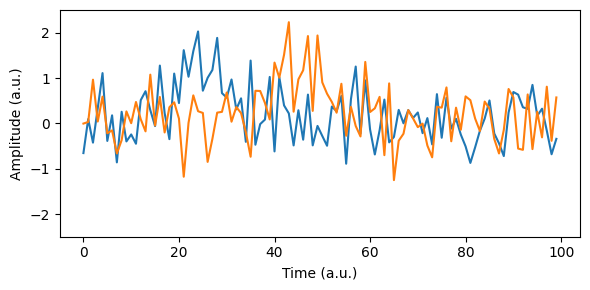

In [108]:
i = 42  
t = np.arange(data.shape[1]) 

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(t, data[i, :, 0])
ax.plot(t, data[i, :, 1])

ax.set_ylim(-2.5, 2.5)

ax.set_xlabel("Time (a.u.)")
ax.set_ylabel("Amplitude (a.u.)")

plt.tight_layout()
plt.savefig(f"/Users/noelkamm/Desktop/Practical Work/figs/synthetic_trial_{i}.pdf", format="pdf", dpi=300)
plt.show()

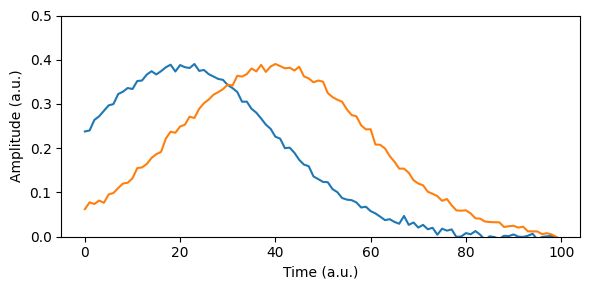

In [107]:
t = np.arange(data.shape[1]) 

fig, ax = plt.subplots(figsize=(6, 3))

plt.plot(t, data_avg[:, 0])
plt.plot(t, data_avg[:, 1])

ax.set_ylim(0, 0.5)

ax.set_xlabel("Time (a.u.)")
ax.set_ylabel("Amplitude (a.u.)")

plt.tight_layout()
plt.savefig(f"/Users/noelkamm/Desktop/Practical Work/figs/average_trials.pdf", format="pdf", dpi=300)
plt.show()

In [16]:
# split the data into training and test set 
X_train, y = split_data(data)

In [17]:
# create training and test loader, batch the data 
train_loader, test_loader = create_data_loaders(X_train, y)

In [18]:
# define the configuration of the model 
config = create_model_config()

In [19]:
# initialize the model 
model = TimeSeriesTransformerForPrediction(config)

In [20]:
# train the model
params = train_model(model, train_loader)

Epoch 1/20, Loss: 1.5922
Epoch 2/20, Loss: 1.5028
Epoch 3/20, Loss: 1.4870
Epoch 4/20, Loss: 1.4832
Epoch 5/20, Loss: 1.4807
Epoch 6/20, Loss: 1.4787
Epoch 7/20, Loss: 1.4779
Epoch 8/20, Loss: 1.4758
Epoch 9/20, Loss: 1.4769
Epoch 10/20, Loss: 1.4773
Epoch 11/20, Loss: 1.4758
Epoch 12/20, Loss: 1.4736
Epoch 13/20, Loss: 1.4723
Epoch 14/20, Loss: 1.4726
Epoch 15/20, Loss: 1.4758
Epoch 16/20, Loss: 1.4749
Epoch 17/20, Loss: 1.4727
Epoch 18/20, Loss: 1.4735
Epoch 19/20, Loss: 1.4718
Epoch 20/20, Loss: 1.4724


In [21]:
# save the model 
model.save_pretrained("./saved_model")

In [22]:
# arrange the parameters in a pd
params_df = arrange_params(params)

In [23]:
# plot mu over time points of specified epoch 
pulse1_mus, pulse2_mus = plot_pulse_mus(params_df)

In [27]:
# generate predictions 
predictions = generate_predictions(model, test_loader)

In [33]:
copy = predictions.copy()

In [34]:
predcitions_df = arrange_params([predictions, copy])

In [40]:
# plot mu over time points of specified epoch 
pulse1_mus, pulse2_mus, pulse1_sigmas, pulse2_sigmas = plot_pulse_mus(predcitions_df)

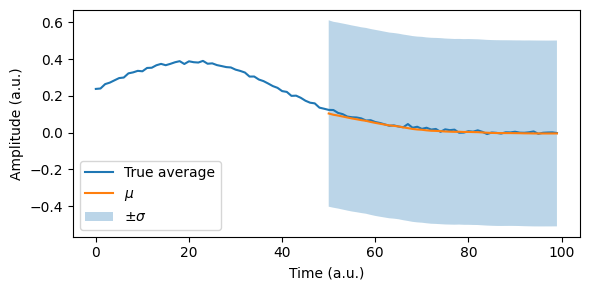

In [88]:

t_x = np.arange(100)                      
t_y = np.arange(50) + 50                  

# Figure and axes
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(t_x, data_avg[:, 0],  label='True average')

ax.plot(t_y, pulse1_mus, label=r'$\mu$')

# Blue filling: ±σ
ax.fill_between(
    t_y,
    pulse1_mus - pulse1_sigmas,
    pulse1_mus + pulse1_sigmas,
    alpha=0.3,
    label=r'$\pm \sigma$'
)

# Labels and legend
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Amplitude (a.u.)')
ax.legend()

fig.tight_layout()

# Save as PDF
fig.savefig('/Users/noelkamm/Desktop/Practical Work/figs/prediction1.pdf')
plt.show()

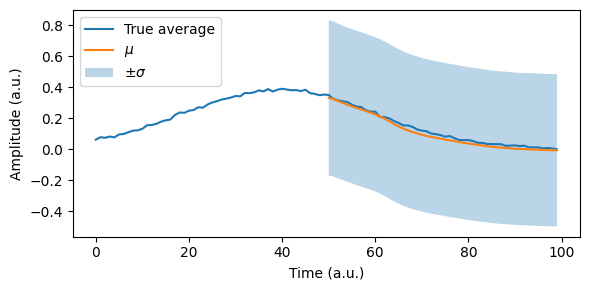

In [89]:
t_x = np.arange(100)                      
t_y = np.arange(50) + 50                  

# Figure and axes
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(t_x, data_avg[:, 1],  label='True average')

ax.plot(t_y, pulse2_mus, label=r'$\mu$')

# Blue filling: ±σ
ax.fill_between(
    t_y,
    pulse2_mus - pulse2_sigmas,
    pulse2_mus + pulse2_sigmas,
    alpha=0.3,
    label=r'$\pm \sigma$'
)

# Labels and legend
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Amplitude (a.u.)')
ax.legend()

fig.tight_layout()

# Save as PDF
fig.savefig('/Users/noelkamm/Desktop/Practical Work/figs/prediction2.pdf')
plt.show()